# Tutorial \#1: Linear Regression

In this tutorial, we'll demonstrate the most basic example of statistical learning, linear regression. We'll perform linear regression in three ways: (1) analytically (2) using `scikit-learn`, and (3) using `flax`. 

Linear regression assumes that the data is generated from the equation $$y = \boldsymbol{w} \cdot \boldsymbol{x} + b + \epsilon$$ where $\boldsymbol{w}$ and $b$ are the parameters of the model and $\epsilon$ represents some noise with an expected value of zero. The goal is to find the params $\boldsymbol{w}$ and $b$ which most accurately describe future data. We learn these parameters using observed input-output data. The data come in the form of N input-output pairs $\{\boldsymbol{x}_i, y_i\}_{i=1}^N$.

A good explanatory resource on linear regression is the lecture notes from [COS324](https://www.cs.princeton.edu/courses/archive/spring19/cos324/) at Princeton:
* [Ordinary Least Squares Linear Regression](https://www.cs.princeton.edu/courses/archive/spring19/cos324/files/linear-regression.pdf)
* [Maximum Likelihood Linear Regression](https://www.cs.princeton.edu/courses/archive/spring19/cos324/files/mle-regression.pdf)
* [Least squares regression with non-linear features](https://www.cs.princeton.edu/courses/archive/spring19/cos324/files/basis-functions.pdf)

### One-dimensional example

Although linear regression is normally applied to multi-dimensional inputs, for this tutorial we'll use a 1-dimensional input variable $x$ for illustration purposes. 

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

We'll assume that our data is 1D and drawn from a distribution in which Gaussian noise is added to a non-linear ground truth distribution.

In [2]:
def ground_truth(x):
    return 3*x - 0.2*x**2 - 0.05 * x**3

def generate_data(key, N_data, L, sigma = 1.0):
    key1, key2 = random.split(key)
    x = random.uniform(key1,(N_data,)) * L
    y = ground_truth(x) + sigma * random.normal(key2, (N_data,))
    return x, y

Let's generate our data by sampling from the above distribution, and plot that data.

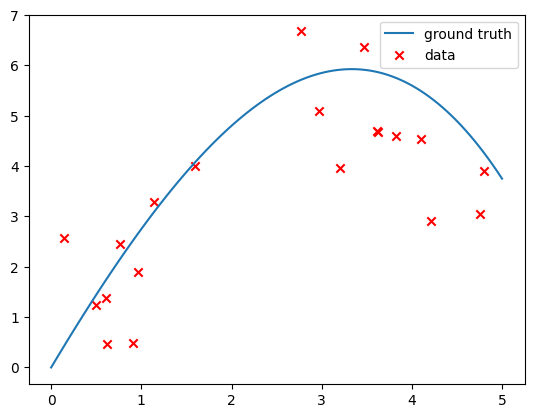

In [3]:
# plot ground truth and data

L = 5 # domain is from 0 to 5
N_data = 20
x_plot = jnp.linspace(0,L,100)

key = random.PRNGKey(0)
x_data, y_data = generate_data(key, N_data=N_data, L=L)

plt.plot(x_plot, ground_truth(x_plot), label='ground truth')
plt.scatter(x_data, y_data, color='red', marker='x', label='data')
plt.legend()
plt.show()

Our linear regression model makes a prediction for the value of $y$, which we write as $\hat{y}$, based on a linear transformation of the input $\boldsymbol{x}$: $$\hat{y}(x) = w x + b.$$ The loss function for a single datapoint will be the squared error loss function $$L(y, \hat{y}) = ||\hat{y} - y||^2.$$ Since we have $N$ datapoints, we can represent our input data as a vector $\boldsymbol{x} \in \mathbb{R}^N$ and our output data as a vector $\boldsymbol{y} \in \mathbb{R}^N$. For $N$ datapoints, our loss function is the mean squared error (MSE) $$L = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - y_i)^2 = \frac{1}{N}||\boldsymbol{\hat{y}} - \boldsymbol{y}||^2.$$ To simplify the notation, we can rewrite the parameters $w$ and $b$ into a vector $\boldsymbol{w} = [w, b] \in \mathbb{R}^2$ and append a $1$ to the data, so that our data is described by a matrix $\boldsymbol{X} = [\boldsymbol{x}, \boldsymbol{1}] \in \mathbb{R}^{N\times 2}$. With this notation, our loss function becomes $$L = \frac{1}{N}||\boldsymbol{X}\boldsymbol{w}-\boldsymbol{y}||^2.$$

In [4]:
X = jnp.concatenate([x_data[:,None], jnp.ones(N_data)[:,None]],axis=1)
print(X.shape)
print(y_data.shape)

(20, 2)
(20,)


### Method 1: Analytically calculate weights and bias

Taking the gradient of the loss function and setting it to zero, we can derive (following the analytic derivations in the COS324 notes) the optimal value of $\boldsymbol{w}$. This is given by $$\boldsymbol{w} = (\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T \boldsymbol{y}.$$

We can now calculate the optimal (MLE) value of $\boldsymbol{w}$ using the above equation.

In [5]:
w_mle = jnp.linalg.inv(X.T @ X) @ X.T @ y_data
print(w_mle.shape)
print(w_mle)
w, b = w_mle

(2,)
[0.7050948 1.6975975]


Although we computed the inverse directly, note that generally it is advised to use `jax.scipy.linalg.solve()` over `jax.numpy.linalg.inv()`.

We can now plot our optimal values of $w$ and $b$ compared to the ground-truth data.

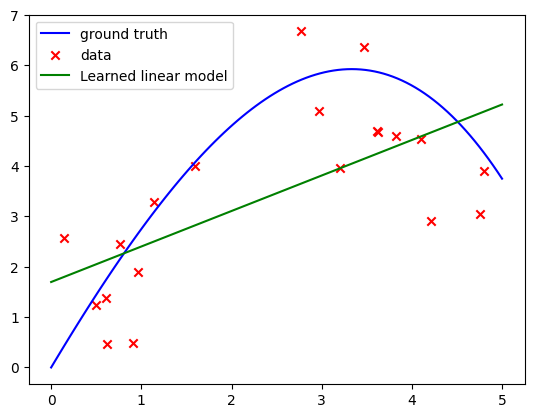

In [6]:
plt.plot(x_plot, ground_truth(x_plot), color='blue', label='ground truth')
plt.scatter(x_data, y_data, color='red', marker='x', label='data')
plt.plot(x_plot, w * x_plot + b, color='green', label='Learned linear model')
plt.legend()
plt.show()

### Method 2: Linear Regression with scikit-learn

Another option is to use `scikit-learn`.

In [7]:
from sklearn.linear_model import LinearRegression

We'll first try fitting the data using the 1D representation of the data ${x}$.

In [8]:
try:
    reg = LinearRegression().fit(x_data, y_data)
except:
    print("ValueError: Expected 2D array, got 1D array instead")

ValueError: Expected 2D array, got 1D array instead


We got an error because `scikit-learn` expects the input data to come in a 2D array, but `x_data` has shape (20,). We'll need to append a dimension to `x_data` before passing it to `sklearn`. 

In [9]:
reg = LinearRegression().fit(x_data[:,None], y_data)

In [10]:
w_skl, b_skl = reg.coef_, reg.intercept_
print(w_skl, b_skl)

[0.7050945] 1.6975977


We can see that we get the same values of $w$ and $b$ as before.

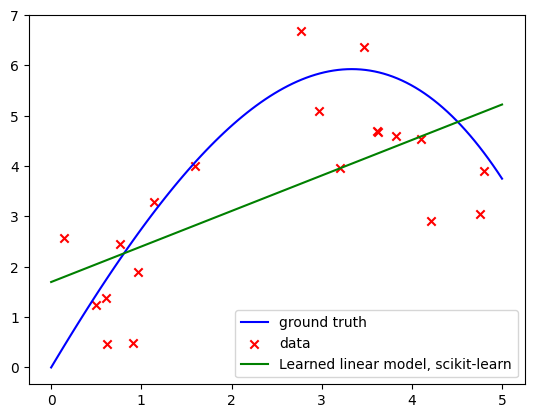

In [11]:
plt.plot(x_plot, ground_truth(x_plot), color='blue', label='ground truth')
plt.scatter(x_data, y_data, color='red', marker='x', label='data')
plt.plot(x_plot, w_skl[0] * x_plot + b_skl, color='green', label='Learned linear model, scikit-learn')
plt.legend()
plt.show()

### Method 3: Using `flax` to minimize the MSE loss function using gradient descent

Since the mean squared error (MSE) loss function is convex and has an analytic solution, we don't need to perform gradient descent to find a minimum. However, if we wanted to, we could also perform gradient descent to minimize the loss function. This would give the same result as computing the loss analytically.

We'll use `flax` to implement and train a linear model. We will use this same code structure to train and implement more complicated neural network models in later tutorials. 

In [12]:
from flax import nnx
import optax

#### 3.1: Understanding `Rngs` in `flax`

PRNG works a little differently in `flax` than in JAX. We initialize a `nnx.Rngs` object as follows: `rngs = nnx.Rngs(seed)` where `seed` is an `int`.

Look at the following code below to see how `nnx.Rngs` works.

In [13]:
rngs = nnx.Rngs(0) # seed is 0 for all streams
print("The first time rngs is called, it gives a key")
print(rngs.params())
print("The key automatically changes each time rngs is called")
print(rngs.dropout())
print("I can call whatever stream I want")
print(rngs.random_stream_whatever_I_want())

# Different streams can have different keys
rngs = nnx.Rngs(0, params=1) # seed is 0 for all streams except for params stream
print("Params stream has seed of 1, has different key")
print(rngs.params()) # print params stream
print("Other streams have seeds of 0, have same keys as before")
print(rngs.dropout()) # print dropout stream
print(rngs.random_stream_whatever_I_want())

The first time rngs is called, it gives a key
Array((), dtype=key<fry>) overlaying:
[1797259609 2579123966]
The key automatically changes each time rngs is called
Array((), dtype=key<fry>) overlaying:
[ 928981903 3453687069]
I can call whatever stream I want
Array((), dtype=key<fry>) overlaying:
[4146024105 2718843009]
Params stream has seed of 1, has different key
Array((), dtype=key<fry>) overlaying:
[ 507451445 1853169794]
Other streams have seeds of 0, have same keys as before
Array((), dtype=key<fry>) overlaying:
[1797259609 2579123966]
Array((), dtype=key<fry>) overlaying:
[ 928981903 3453687069]


#### 3.2: Create linear model in `flax`

We'll now create a subclass of `nnx.Module` which represents our linear regression model. We need to implement `__init__` and `__call__` methods.  

In [14]:
class LinearRegression(nnx.Module):
    def __init__(self, din: int, rngs: nnx.Rngs):
        key = rngs.params()
        self.w = nnx.Param(random.normal(key, (din,)))
        self.b = nnx.Param(0.0)

    def __call__(self, x: jax.Array):
        return x @ self.w + self.b

In [15]:
model = LinearRegression(1, rngs = nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.sgd(1e-3))
y = model(jnp.asarray([0.0]))
print(y)
nnx.display(model)

0.0
LinearRegression(
  w=Param(
    value=Array([1.0040143], dtype=float32)
  ),
  b=Param(
    value=0.0
  )
)


#### 3.3: Write loss function and train model

Our training step takes advantage of the fact that `nnx.Module` classes are mutable, meaning that the params are stored and updated within the class. By calling `optimizer.update(grads)`, the model parameters are updated automatically. 

In [16]:
@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model: LinearRegression):
        y_pred = model(x)
        return jnp.mean((y - y_pred)**2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss

In [17]:
X = x_data.reshape(N_data, 1)

print(model(X).shape)
print(y_data.shape)
try:
    loss = train_step(model, optimizer, X, y_data)
    print(loss)
except:
    print("shape of x_data and y_data incorrect")

(20,)
(20,)
2.909177


In [18]:
N_train = 10000
losses = []
for _ in range(N_train):
    loss = train_step(model, optimizer, X, y_data)
    losses.append(loss)

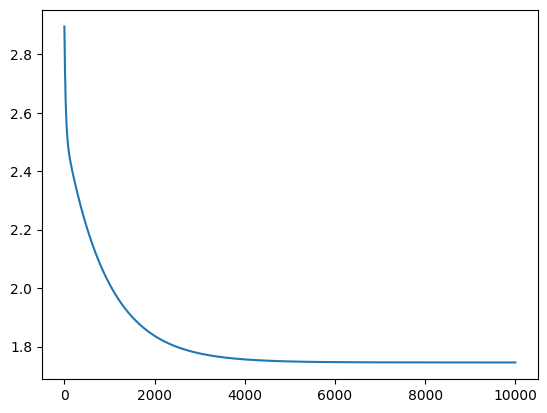

In [19]:
plt.plot(losses)
plt.show()

In [20]:
print(model.w, model.b)

Param(
  value=Array([0.7073139], dtype=float32)
) Param(
  value=Array(1.6902171, dtype=float32)
)


The values of $w$ and $b$ computed using gradient descent are almost identical to the analytically computed $w$ and $b$ from methods #1 and #2.

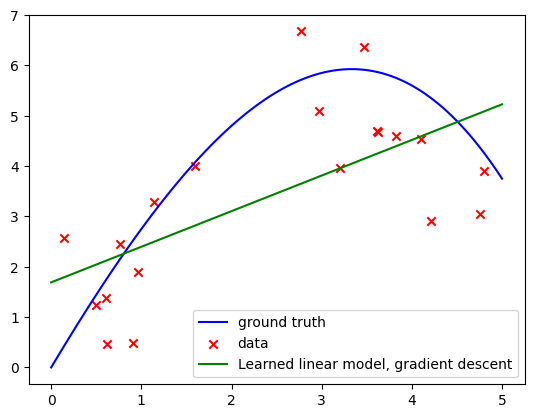

In [21]:
plt.plot(x_plot, ground_truth(x_plot), color='blue', label='ground truth')
plt.scatter(x_data, y_data, color='red', marker='x', label='data')
plt.plot(x_plot, model.w[0] * x_plot + model.b, color='green', label='Learned linear model, gradient descent')
plt.legend()
plt.show()